# Devnagari Digit Classification with Fully Connected Neural Network
Worksheet 4 6CS012 - Artificial Intelligence and Machine Learning.

## Step 1: Libraries Are Imported
All necessary libraries for data processing, model building, training, and visualization are imported in this step.


In [1]:
# Import libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from PIL import Image
import zipfile
from google.colab import drive
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Constants
IMG_HEIGHT, IMG_WIDTH = 28, 28
NUM_CLASSES = 10
BATCH_SIZE = 128
EPOCHS = 20
VALIDATION_SPLIT = 0.2

In [2]:
# Constants
IMG_HEIGHT, IMG_WIDTH = 28, 28
NUM_CLASSES = 10
BATCH_SIZE = 128
EPOCHS = 20
VALIDATION_SPLIT = 0.2

## Step 2: Google Drive Is Mounted and Dataset Is Extracted
The dataset, stored in Google Drive as a `.zip` file, is accessed by mounting Drive. The dataset is then extracted to a temporary directory in Colab.

In [3]:
def mount_google_drive():
    drive.mount('/content/drive')
    return '/content/drive/MyDrive'

def extract_zip_dataset(zip_path, extract_dir='/content/dataset'):
    """
    Extract the dataset from a zip file to a specified directory.

    Args:
        zip_path (str): Path to the .zip file in Google Drive.
        extract_dir (str): Directory where the dataset will be extracted.

    Returns:
        str: Path to the extracted dataset directory.
    """
    if not os.path.exists(extract_dir):
        os.makedirs(extract_dir)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    return extract_dir

# Mount Google Drive
drive_root = mount_google_drive()

# Extract the dataset
zip_file_path = "/content/drive/MyDrive/AI&ML/Workshop_4/Copy of devnagari digit.zip"
extract_dir = extract_zip_dataset(zip_file_path)

# Adjust for nested folder structure
nested_dir = os.path.join(extract_dir, "DevanagariHandwrittenDigitDataset")
train_dir = os.path.join(nested_dir, "Train")
test_dir = os.path.join(nested_dir, "Test")
print(f"Training directory: {train_dir}")
print(f"Test directory: {test_dir}")

Mounted at /content/drive
Training directory: /content/dataset/DevanagariHandwrittenDigitDataset/Train
Test directory: /content/dataset/DevanagariHandwrittenDigitDataset/Test


## Step 3: Dataset Is Loaded and Preprocessed
Devnagari digit images from the `Train` and `Test` folders are loaded, resized to 28x28, and normalized. The labels are one-hot encoded for training.

In [4]:
def load_images_from_folder(folder):
    """
    Load Devnagari digit images and labels from a folder structure using PIL.

    Args:
        folder (str): Path to the folder (e.g., '/content/dataset/DevanagariHandwrittenDigitDataset/Train/').

    Returns:
        tuple: (images, labels) as NumPy arrays, where images are normalized and flattened.
    """
    images = []
    labels = []
    class_names = [f"digit_{i}" for i in range(10)]  # Expected: digit_0 to digit_9

    for class_name in class_names:
        class_path = os.path.join(folder, class_name)
        if not os.path.isdir(class_path):
            print(f"Warning: {class_path} not found, skipping.")
            continue
        label = int(class_name.split('_')[1])
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            try:
                img = Image.open(img_path).convert("L")
                img = img.resize((IMG_HEIGHT, IMG_WIDTH))
                img = np.array(img) / 255.0
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    images = np.array(images).reshape(-1, IMG_HEIGHT * IMG_WIDTH)
    labels = to_categorical(np.array(labels), NUM_CLASSES)
    return images, labels

# Load the dataset
x_train, y_train = load_images_from_folder(train_dir)
x_test, y_test = load_images_from_folder(test_dir)
print(f"Training set shape: {x_train.shape}, Labels: {y_train.shape}")
print(f"Test set shape: {x_test.shape}, Labels: {y_test.shape}")

Training set shape: (17000, 784), Labels: (17000, 10)
Test set shape: (3000, 784), Labels: (3000, 10)


## Step 4: Dataset Is Explored
Sample images are visualized, and the class distribution is checked to ensure the dataset is balanced.

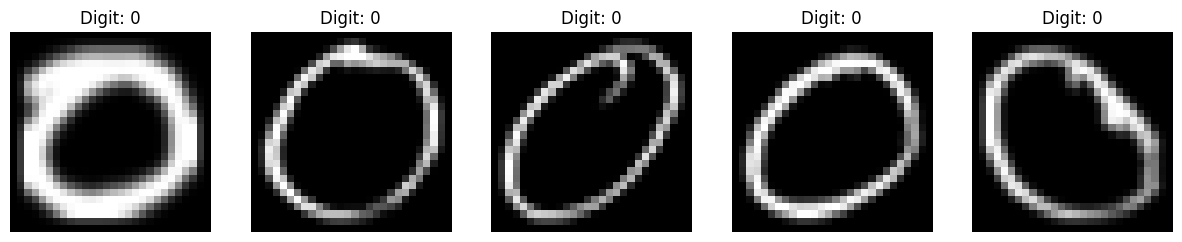


Class distribution in Full Training Set:
Class 0: 1700 samples
Class 1: 1700 samples
Class 2: 1700 samples
Class 3: 1700 samples
Class 4: 1700 samples
Class 5: 1700 samples
Class 6: 1700 samples
Class 7: 1700 samples
Class 8: 1700 samples
Class 9: 1700 samples

Class distribution in Training Split:
Class 0: 1700 samples
Class 1: 1700 samples
Class 2: 1700 samples
Class 3: 1700 samples
Class 4: 1700 samples
Class 5: 1700 samples
Class 6: 1700 samples
Class 7: 1700 samples

Class distribution in Validation Split:
Class 8: 1700 samples
Class 9: 1700 samples

Class distribution in Test Set:
Class 0: 300 samples
Class 1: 300 samples
Class 2: 300 samples
Class 3: 300 samples
Class 4: 300 samples
Class 5: 300 samples
Class 6: 300 samples
Class 7: 300 samples
Class 8: 300 samples
Class 9: 300 samples


In [5]:
def visualize_samples(x_data, y_data, num_samples=5):
    """
    Visualize a few sample images from the dataset along with their labels.

    Args:
        x_data (np.ndarray): Image data (flattened).
        y_data (np.ndarray): One-hot encoded labels.
        num_samples (int): Number of samples to display.
    """
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        img = x_data[i].reshape(28, 28)
        label = np.argmax(y_data[i])
        plt.imshow(img, cmap='gray')
        plt.title(f"Digit: {label}")
        plt.axis('off')
    plt.show()

def check_class_distribution(y_data, set_name="Dataset"):
    """
    Check the class distribution in the dataset.

    Args:
        y_data (np.ndarray): One-hot encoded labels.
        set_name (str): Name of the dataset (e.g., 'Training', 'Validation').
    """
    labels = np.argmax(y_data, axis=1)
    unique, counts = np.unique(labels, return_counts=True)
    print(f"\nClass distribution in {set_name}:")
    for cls, count in zip(unique, counts):
        print(f"Class {cls}: {count} samples")

# Visualize 5 samples from the training set
visualize_samples(x_train, y_train, num_samples=5)

# Check class distribution
val_split = 0.2
num_train = int((1 - val_split) * len(x_train))
x_train_split, x_val_split = x_train[:num_train], x_train[num_train:]
y_train_split, y_val_split = y_train[:num_train], y_train[num_train:]

check_class_distribution(y_train, "Full Training Set")
check_class_distribution(y_train_split, "Training Split")
check_class_distribution(y_val_split, "Validation Split")
check_class_distribution(y_test, "Test Set")

## Step 5: Model Is Built
A Fully Connected Neural Network with 3 hidden layers (64, 128, 256 neurons) is constructed. ReLU activations and dropout are used to reduce overfitting.

In [12]:
def build_fcn_model():
    """
    Build a Fully Connected Neural Network (FCN) with ReLU and Dropout for Devnagari digit classification.

    Returns:
        keras.Model: Compiled FCN model with 3 hidden layers, dropout, and an output layer.
    """
    model = models.Sequential([
        layers.Input(shape=(IMG_HEIGHT * IMG_WIDTH,)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer='sgd',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_fcn_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 64)                  │          50,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,154 (367.79 KB)

 Trainable params: 94,154 (367.79 KB)

 Non-trainable params: 0 (0.00 B)

## Step 6: Model Is Trained
The model is trained for 20 epochs with a batch size of 128 and a 20% validation split. Data is shuffled to ensure a representative validation set, and early stopping is applied to prevent overfitting.

In [13]:
def train_model(model, x_train, y_train):
    """
    Train the FCN model with specified parameters and callbacks, with shuffled data.

    Args:
        model (keras.Model): The FCN model to train.
        x_train (np.ndarray): Training images.
        y_train (np.ndarray): Training labels (one-hot encoded).

    Returns:
        History: Training history object containing loss and accuracy metrics.
    """
    # Shuffle the training data
    indices = np.arange(x_train.shape[0])
    np.random.shuffle(indices)
    x_train_shuffled = x_train[indices]
    y_train_shuffled = y_train[indices]

    callbacks = [
        ModelCheckpoint(filepath='/content/devnagari_fcn_best.keras', monitor='val_loss', save_best_only=True),
        EarlyStopping(monitor='val_loss', patience=6)
    ]

    history = model.fit(
        x_train_shuffled, y_train_shuffled,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=VALIDATION_SPLIT,
        callbacks=callbacks,
        verbose=1
    )
    return history

history = train_model(model, x_train, y_train)

Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.1316 - loss: 2.2918 - val_accuracy: 0.5097 - val_loss: 2.0908
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2990 - loss: 2.0796 - val_accuracy: 0.6618 - val_loss: 1.6773
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4357 - loss: 1.7262 - val_accuracy: 0.7509 - val_loss: 1.1826
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5347 - loss: 1.3794 - val_accuracy: 0.7871 - val_loss: 0.8780
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6140 - loss: 1.1304 - val_accuracy: 0.8176 - val_loss: 0.7097
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6633 - loss: 0.9753 - val_accuracy: 0.8324 - val_loss: 0.6011
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6993 - loss: 0.8713 - val_accuracy: 0.8482 - val_loss: 0.5270
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7195 - loss: 0.7876 - val_accuracy: 0

## Step 7: Training History Is Visualized
Training and validation loss and accuracy are plotted to assess the model’s performance over epochs.

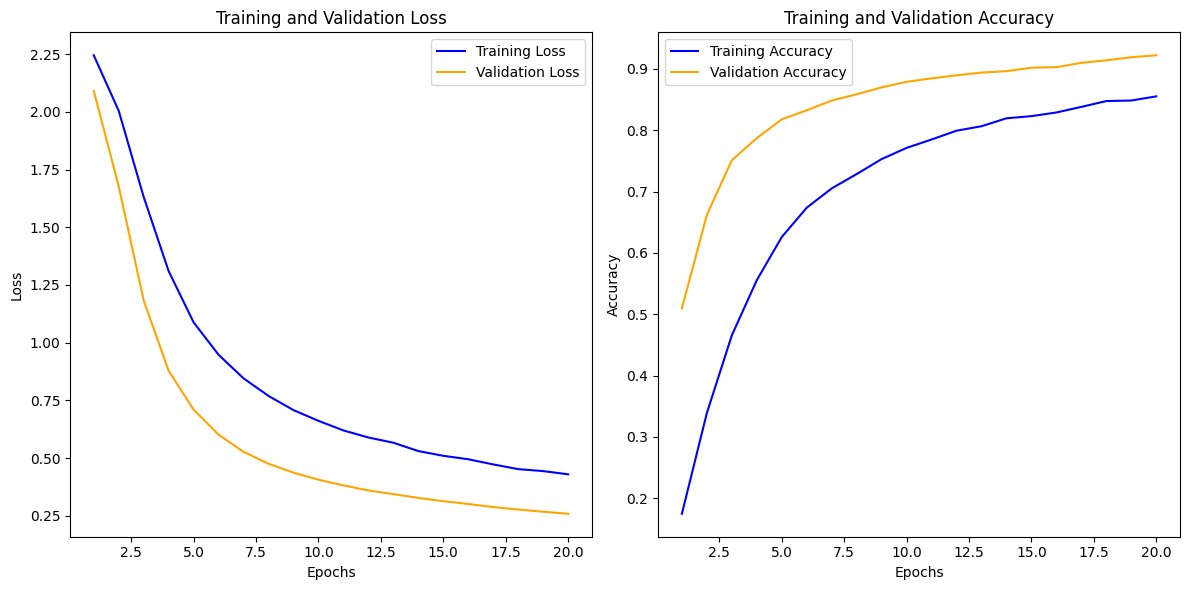

In [14]:
def plot_training_history(history):
    """
    Plot training and validation loss and accuracy.

    Args:
        history (History): Training history object from model.fit().
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', color='blue')
    plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy', color='blue')
    plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

## Step 8: Model Is Evaluated and Predictions Are Visualized
The model is evaluated on the test set, predictions are made, and results are visualized with a confusion matrix.

94/94 - 1s - 6ms/step - accuracy: 0.9273 - loss: 0.2513
Test accuracy: 0.9273
Test loss: 0.2513
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Predicted label for first test image: 0
True label for first test image: 0


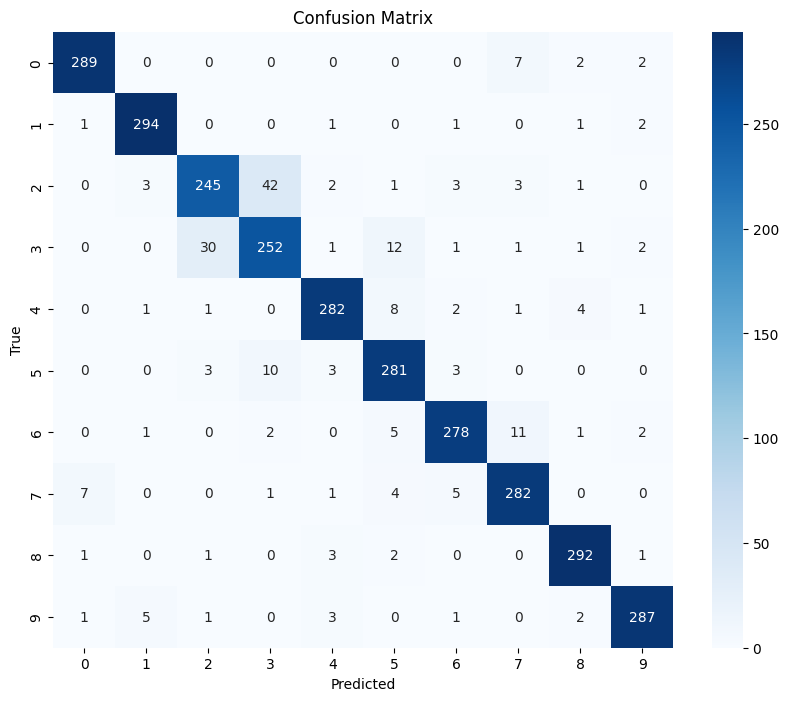

In [15]:
def evaluate_and_predict(model, x_test, y_test):
    """
    Evaluate the model on test data, make predictions, and visualize results.

    Args:
        model (keras.Model): Trained FCN model.
        x_test (np.ndarray): Test images.
        y_test (np.ndarray): Test labels (one-hot encoded).
    """
    # Evaluate the model
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    print(f"Test accuracy: {test_acc:.4f}")
    print(f"Test loss: {test_loss:.4f}")

    # Make predictions
    predictions = model.predict(x_test)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(y_test, axis=1)

    # Print a sample prediction
    print(f"\nPredicted label for first test image: {predicted_labels[0]}")
    print(f"True label for first test image: {true_labels[0]}")

    # Visualize the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_and_predict(model, x_test, y_test)

## Step 9: Model Is Saved and Loaded
The trained model is saved in the native Keras format, and it is reloaded to verify performance.


Evaluating loaded model:
94/94 - 1s - 12ms/step - accuracy: 0.9797 - loss: 0.0735
Test accuracy: 0.9797
Test loss: 0.0735
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Predicted label for first test image: 0
True label for first test image: 0


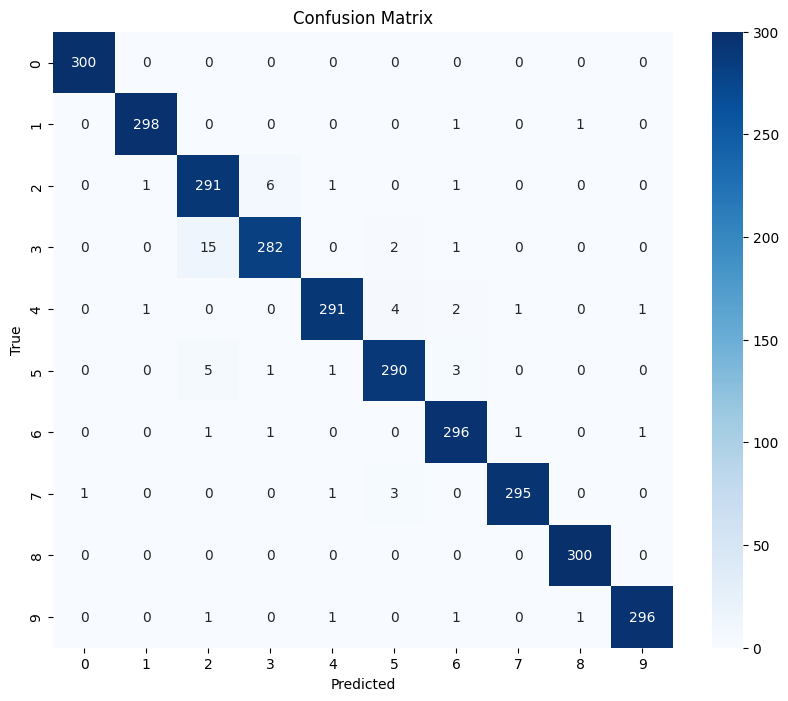

In [10]:
# Save the model
model.save('/content/devnagari_fcn_final.keras')

# Load the model
loaded_model = tf.keras.models.load_model('/content/devnagari_fcn_final.keras')
print("\nEvaluating loaded model:")
evaluate_and_predict(loaded_model, x_test, y_test)

## Step 10: Model Is Downloaded
The saved model file is downloaded to the local machine.

In [11]:
from google.colab import files
files.download('/content/devnagari_fcn_final.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>